In [1]:
import pandas as pd 
from sklearn import preprocessing 
import numpy as np 
import matplotlib.pyplot as plt 


# Clean And Normalize Monthly Generation Data 
# Read in excel sheet containing data. 
data = pd.read_excel('Solar Workbook.xlsx', sheet_name = 'Combined Data for Project')

# Remove newlines and extra spacing 
data.columns = [x.replace("\n", " ") for x in data.columns.to_list()]

# Record monthly generations 
gen = data[["Netgen January", "Netgen February", "Netgen March", "Netgen April", "Netgen May", 
            "Netgen June", "Netgen July", "Netgen August", "Netgen September", "Netgen October", 
           "Netgen November", "Netgen December"]]

# Dots symbolize zero generation
gen = gen.replace(['.'],'0') 

# Change data types 
gen = gen.astype(int)

# Nameplate Capacity is the best estimate for size of the plant. It represents maximum amount of energy a plant could generate 
# Adjust all the plants generation for size and the number of days per month 
nameplateCapacity = data["Nameplate Capacity (MW)"] 
daysInMonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

# Apply formula for efficiency: 
for i in range(12): 
    gen.iloc[:,i] = (gen.iloc[:,i]).div(nameplateCapacity) 
    gen.iloc[:,i] = gen.iloc[:,i].div(daysInMonth[i])

# Normalize the efficiencies to values between 0 and 1 
gen = (gen - gen.min())/(gen.max() - gen.min()) 


In [2]:
from sklearn.preprocessing import LabelEncoder

# Establish relevant predictive data 
# I worked through to identify the features who could be predictive of solar use. 
valuableFeatures = data[["Sector Name", "Latitude", "Longitude", "State", "Net Generation (Megawatthours)"]] 

# Check for missing features 
print(valuableFeatures.isnull().sum())

# Check for categorical features: 
print(valuableFeatures.dtypes) 

# Concatenate Data: 
dataFrames = [gen, nameplateCapacity, valuableFeatures] 
df = pd.concat(dataFrames, axis = 1)

# Label encode the categorical data 
labelencoder = LabelEncoder() 
df['Sector Name'] = labelencoder.fit_transform(df['Sector Name'])

df['State'] = labelencoder.fit_transform(df['State']) 
# Create a mapping to determine what the labels correspond to. 
mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))

gen.describe()

Sector Name                       0
Latitude                          0
Longitude                         0
State                             0
Net Generation (Megawatthours)    0
dtype: int64
Sector Name                        object
Latitude                          float64
Longitude                         float64
State                              object
Net Generation (Megawatthours)      int64
dtype: object


,Netgen January,Netgen February,Netgen March,Netgen April,Netgen May,Netgen June,Netgen July,Netgen August,Netgen September,Netgen October,Netgen November,Netgen December
count,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000
mean,0.190989,0.193920,0.162477,0.203352,0.157427,0.199940,0.215451,0.187275,0.179191,0.167531,0.162106,0.023785
std,0.106693,0.099723,0.075321,0.095084,0.070655,0.085849,0.093345,0.079506,0.072005,0.071138,0.067917,0.025467
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.133108,0.157391,0.142667,0.167123,0.138095,0.177333,0.183333,0.160511,0.158182,0.134896,0.128054,0.015931
50%,0.199167,0.203000,0.177333,0.216438,0.166250,0.208315,0.221917,0.190682,0.184416,0.168067,0.163100,0.021415
75%,0.262500,0.247333,0.203733,0.263836,0.192857,0.243643,0.261084,0.230202,0.211400,0.206349,0.202190,0.030176
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


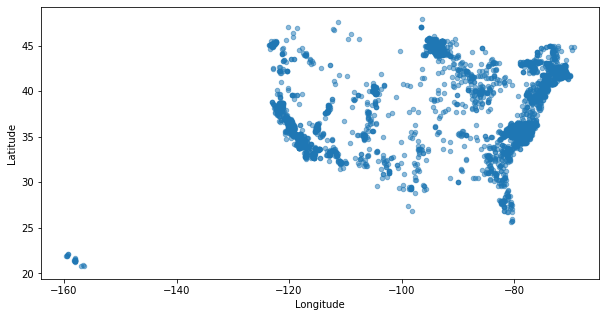

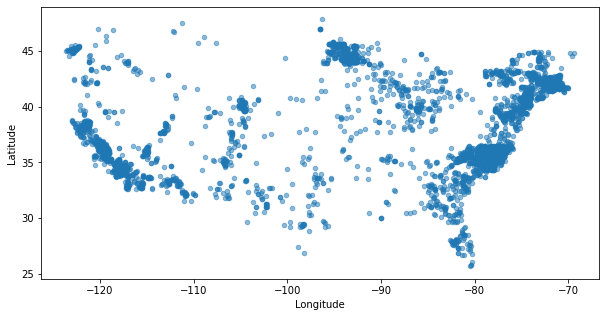

In [3]:
# Visualize latitude and longitude and make adjustments 

# Graph the data: 
df.plot(kind = "scatter", x = "Longitude", y = "Latitude", 
        alpha = 0.5, figsize = (10, 5))
plt.savefig("US Solar Points 1.pdf")


# Since HI is far off, we will remove HI samples 
# Get the state's label code 
df.drop(df.index[df['State'] == mapping.get('HI')], inplace = True)

df.plot(kind = "scatter", x = "Longitude", y = "Latitude", 
        alpha = 0.5, figsize = (10, 5))
plt.savefig("US Solar Points 2.pdf")







In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error,mean_squared_error
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Predict the state just using energy data: 
# Logistic Regression Model: 
normalizer = StandardScaler() 
dfPredictState = df.drop(["Latitude", "Longitude", "Sector Name", "Nameplate Capacity (MW)", "Net Generation (Megawatthours)"], axis = 1)
# Split into testing and trianing data: 
x_train, x_test, y_train, y_test = train_test_split(dfPredictState.drop('State', axis = 1).values, 
                                                    dfPredictState["State"].values, 
                                                    test_size = 0.2, 
                                                    random_state = 0) 

# Create logistic regression model: 
lr = LogisticRegression(solver='lbfgs', max_iter=200) 

# Fit the logistic regression model: 
lr.fit(x_train, y_train) 
y_pred = lr.predict(x_test) 

# Find the accuracy of this logistic regression model: 
acc = accuracy_score(y_test, y_pred) 
print(acc) 

0.46382428940568476


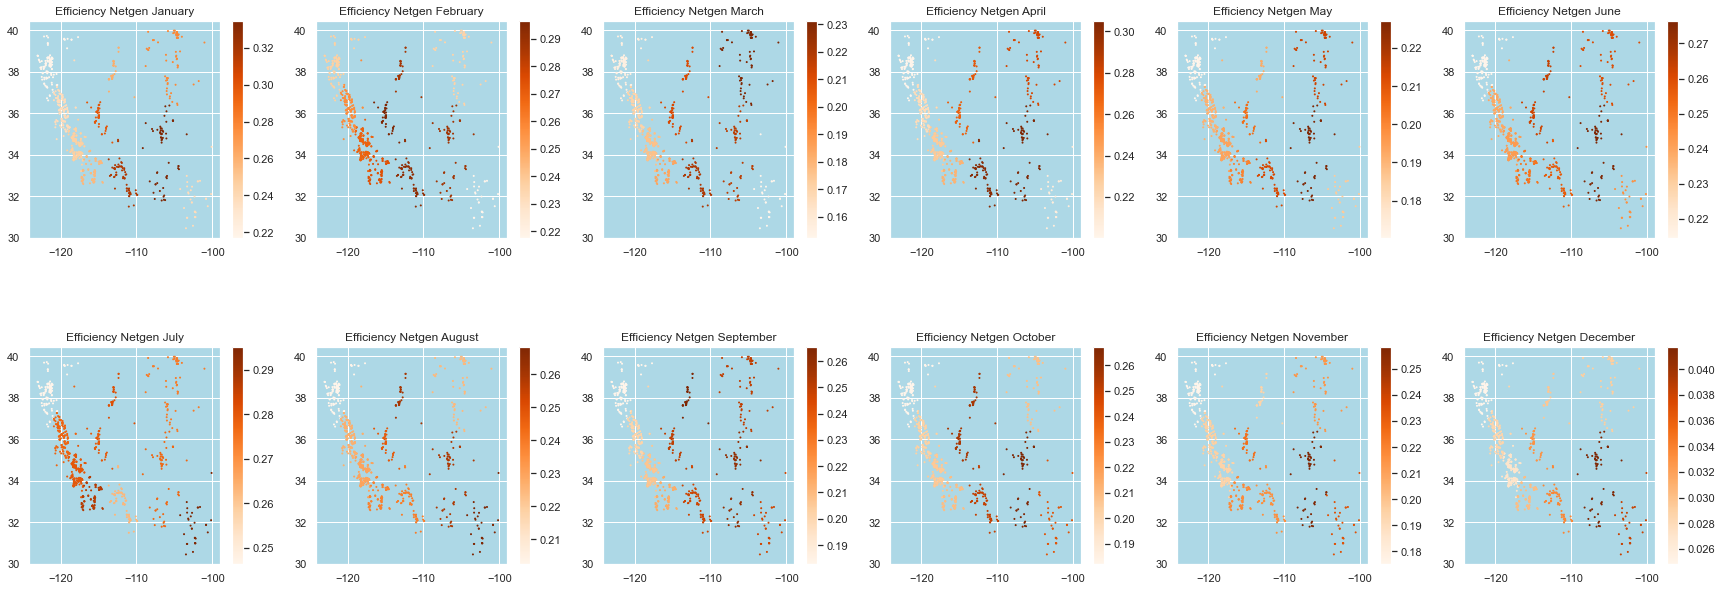

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from random import shuffle
import random 
random.seed(123)
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering 
import seaborn as sns; sns.set()

# # Create a clustering model for the entire United States: 
# plt.figure(figsize = (5, 60))
# plt.subplots_adjust(hspace = 0.5) 
# plt.title("K-Means Clustering Monthly Power Plant Efficiencies Grouped") 
# for i in range(0, 12): 
#     X = df.loc[:, [df.columns[i], "Latitude", "Longitude"]] 
#     X.drop(X.index[df[df.columns[1]] < 0.01], inplace=True)
#     kmeans = KMeans(n_clusters = 20, init = 'k-means++') 
#     kmeans.fit(X) 
#     X['cluster_label'] = kmeans.fit_predict(X) 
#     centers = kmeans.cluster_centers_ 
#     labelSearch = pd.DataFrame({'cluster_label' : range(0, len(centers)), 
#                                'Efficiency' : centers[:, 0]}) 
#     X = pd.merge(X, labelSearch, on = 'cluster_label')
#     ax = plt.subplot(12, 1, i + 1) 
#     ax.set_title("Efficiency of " + df.columns[i])
#     plt.scatter(X['Longitude'], X['Latitude'], c = X['Efficiency'], s = 2, cmap = 'viridis') 
#     plt.colorbar()
#     plt.scatter(centers[:, 2], centers[:, 1], c='black', s=10, alpha=0.5) 
# plt.savefig("K-Means Monthly Power Plant Efficiencies Grouped.pdf")
# plt.show() 

# Create a clustering model for the Southwest United States: 
plt.figure(figsize = (30, 10)) 
plt.subplots_adjust(hspace = 0.5) 
plt.title("K-Means Monthly Power Plant Efficiencies Southwest US")
for i in range(0, 12): 
    X = df.loc[:, [df.columns[i], "Latitude", "Longitude"]]     
    X.drop(X.index[X['Latitude'] > 40], inplace = True)
    X.drop(X.index[X['Latitude'] < 30], inplace = True)
    X.drop(X.index[X['Longitude'] > -100], inplace = True) 
    X.drop(X.index[X[X.columns[1]] < 0.01], inplace=True)

    kmeans = KMeans(n_clusters = 10, init = 'k-means++') 
    kmeans.fit(X) 

    X['cluster_label'] = kmeans.fit_predict(X) 
    df['cluster_label'] = X['cluster_label']
    
    centers = kmeans.cluster_centers_ 
    X['Efficiency'] = df.groupby('cluster_label')[df.columns[i]].transform('mean') 

    ax = plt.subplot(2, 6, i + 1) 
    ax.set_facecolor('lightblue') 
    ax.set_title("Efficiency " + df.columns[i])
    plt.scatter(X['Longitude'], X['Latitude'], c = X['Efficiency'], s = 1, cmap = 'Oranges')
    plt.colorbar()
plt.savefig("K-Means Monthly Power Plant Efficiencies Southwest US.pdf") 
plt.show()


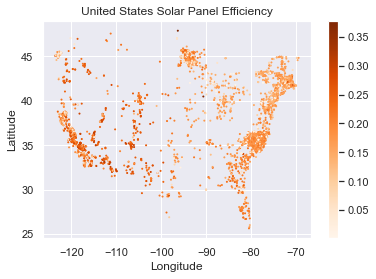

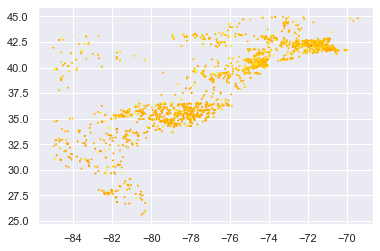

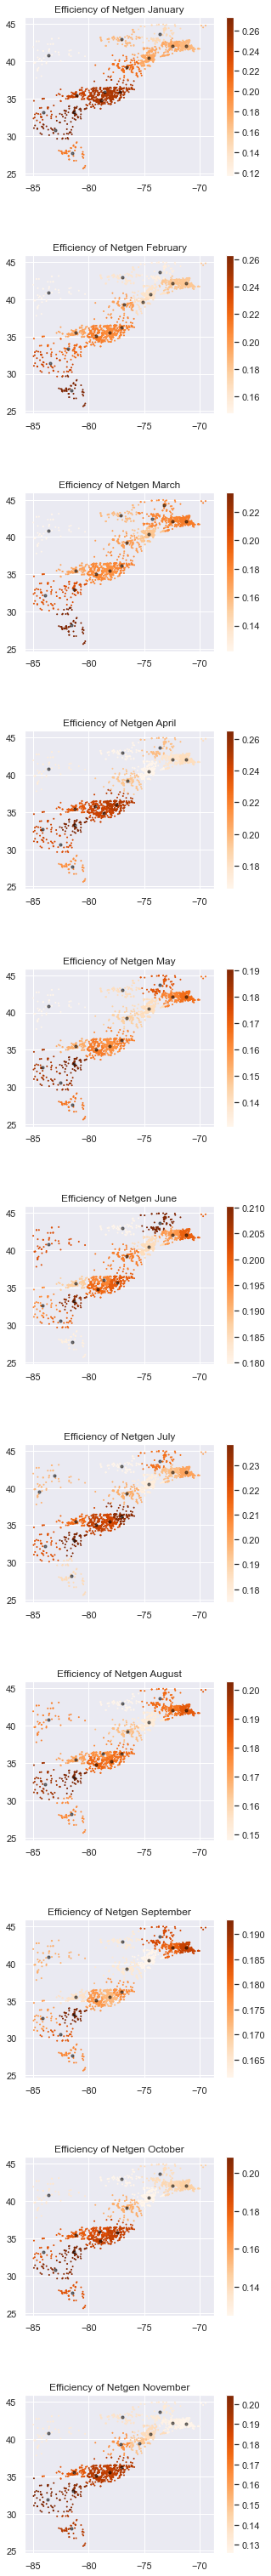

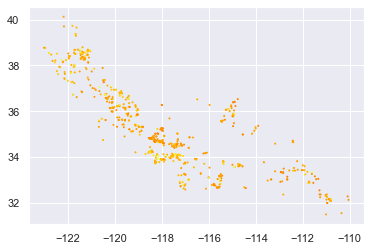

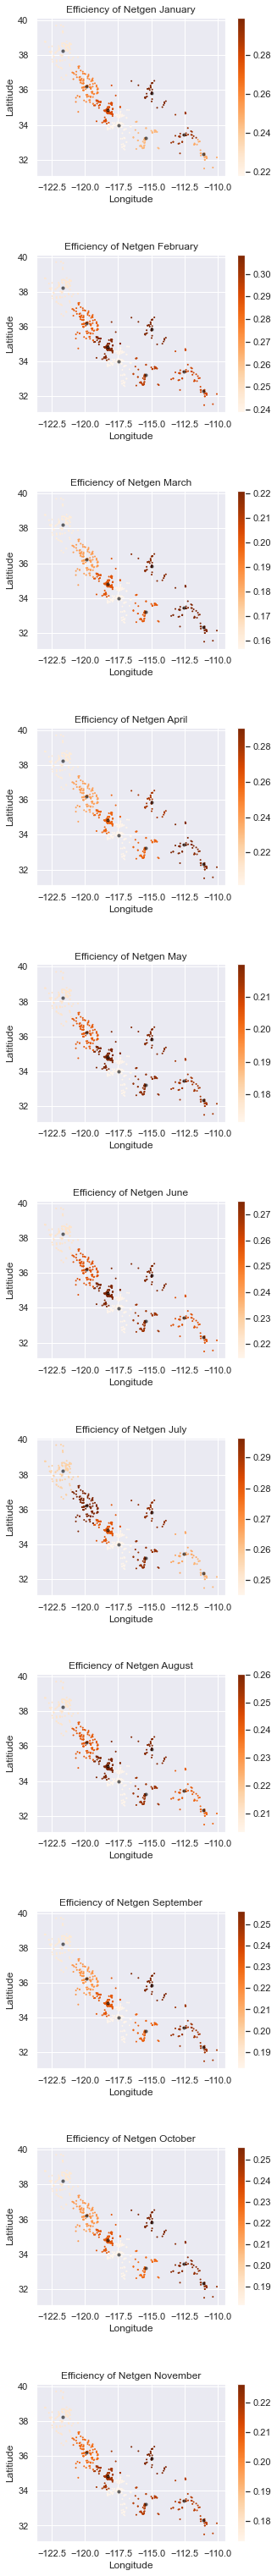

In [6]:
# Review efficiencies in the United States: 
df[df.columns[0:12]] = df[df.columns[0:12]][df[df.columns[0:12]] >= .001]
df[df.columns[0:12]] = df[df.columns[0:12]][df[df.columns[0:12]] < .4] 
df['Average Efficiency'] = df[df.columns[1:12]].mean(axis = 1, skipna = True) 
df = df[df['Average Efficiency'].notna()] 
plt.scatter(df['Longitude'], df['Latitude'], c = df['Average Efficiency'], s = 1, cmap = 'Oranges', zorder = 2)
plt.title("United States Solar Panel Efficiency") 
plt.xlabel("Longitude") 
plt.ylabel("Latitude") 
plt.colorbar() 
plt.savefig("US Solar Efficiency")
plt.show()

# Apply K-Means Clustering to the Eastern and Western Seaboards: 


# Eastern Seaboard: 
dfEast = df.copy(); 
dfEast.drop(dfEast.index[dfEast['Longitude'] < -85], inplace = True); 
plt.scatter(dfEast['Longitude'], dfEast['Latitude'], c = dfEast['Average Efficiency'], s = 1, cmap = 'Wistia', zorder = 2)

plt.figure(figsize = (5, 60)) 
plt.subplots_adjust(hspace = 0.5) 
plt.title("K-Means Monthly Power Plant Efficiencies Eastern Seaboard")
dfEast = dfEast.fillna(0)
for i in range(0, 11): 
    X = dfEast.loc[:, [dfEast.columns[i], "Latitude", "Longitude"]] 
    X.drop(X.index[dfEast[dfEast.columns[1]] < 0.01], inplace=True)
    kmeans = KMeans(n_clusters = 15, init = 'k-means++') 
    kmeans.fit(X) 
    X['cluster_label'] = kmeans.fit_predict(X) 
    centers = kmeans.cluster_centers_ 
    labelSearch = pd.DataFrame({'cluster_label' : range(0, len(centers)), 
                               'Efficiency' : centers[:, 0]}) 
    X = pd.merge(X, labelSearch, on = 'cluster_label')
    ax = plt.subplot(12, 1, i + 1) 
    ax.set_title("Efficiency of " + df.columns[i])
    plt.scatter(X['Longitude'], X['Latitude'], c = X['Efficiency'], s = 1, cmap = 'Oranges')

    plt.colorbar()
    plt.scatter(centers[:, 2], centers[:, 1], c='black', s=10, alpha=0.5) 
plt.savefig("K-Means Monthly Eastern Seaboard.pdf") 
plt.show()

# Western Seaboard: 
dfWest = df.copy(); 
dfWest.drop(dfWest.index[dfWest['Longitude'] > -110], inplace = True); 
dfWest.drop(dfWest.index[dfWest['Latitude'] > -(1/2)*(dfWest['Longitude'] + 70) + 14.2], inplace = True);            
plt.scatter(dfWest['Longitude'], dfWest['Latitude'], c = dfWest['Average Efficiency'], s = 1, cmap = 'Wistia', zorder = 2)

plt.figure(figsize = (5, 60)) 
plt.subplots_adjust(hspace = 0.5) 
plt.title("K-Means Monthly Power Plant Efficiencies Western Seaboard")
dfWest = dfWest.fillna(0)
for i in range(0, 11): 
    X = dfWest.loc[:, [dfWest.columns[i], "Latitude", "Longitude"]] 
    X.drop(X.index[dfWest[dfWest.columns[1]] < 0.01], inplace=True)
    kmeans = KMeans(n_clusters = 8, init = 'k-means++') 
    kmeans.fit(X) 
    X['cluster_label'] = kmeans.fit_predict(X) 
    centers = kmeans.cluster_centers_ 
    labelSearch = pd.DataFrame({'cluster_label' : range(0, len(centers)), 
                               'Efficiency' : centers[:, 0]}) 
    X = pd.merge(X, labelSearch, on = 'cluster_label')
    ax = plt.subplot(12, 1, i + 1) 
    ax.set_title("Efficiency of " + dfWest.columns[i])
    plt.scatter(X['Longitude'], X['Latitude'], c = X['Efficiency'], s = 1, cmap = 'Oranges')
    plt.xlabel("Longitude") 
    plt.ylabel("Latitiude")
    plt.colorbar()
    plt.scatter(centers[:, 2], centers[:, 1], c='black', s=10, alpha=0.5) 
plt.savefig("K-Means Monthly Western Seaboard.pdf") 
plt.show()


In [7]:
# Source: https://github.com/vinsci/geohash 
# Edited by Will Schenk 
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection 
import matplotlib.image as mpimg 
import geohash as gh
import pygeohash as pgh 
import geohash

def printMap(df): 
    def build_geohash_box(current_geohash):
        b = geohash.bbox(current_geohash)
        polygon = [(b['w'], b['s']), (b['w'], b['n']), (b['e'], b['n']), (b['e'], b['s'],), (b['w'], b['s'])]
        return polygon

    #__________________________________________________
    # Created the following:
    # Take in both to prevent duplicates from not being unique. 
    geohashHolderMap = df[['geohash', 'geohashAverage']]
    geohashHolderMap = geohashHolderMap.drop_duplicates()
    
    geohashHolder = geohashHolderMap['geohash'] # All the geohashes 
    geohashColorHolder = geohashHolderMap['geohashAverage'] # Geohash average value 
    geohashHolder = geohashHolder.to_numpy() 
    geohashColorHolder = geohashColorHolder.to_numpy() 
    #__________________________________________________
    arr = np.empty(len(geohashHolder), dtype=object) 
    
    for i in range(len(geohashHolder)): 
        arr[i] = Polygon(build_geohash_box(geohashHolder[i]), True) 

    ax = df.plot(kind = "scatter", x = "Longitude", y = "Latitude", 
            alpha = 1, figsize = (10, 5), zorder = 1, color = 'black') 
    
    patches = PatchCollection(arr, cmap = 'Oranges', alpha = .8)
    colors = geohashColorHolder
    patches.set_array(colors)
    # patches.set_ec('blue')
    ax.add_collection(patches)
    plt.colorbar(patches) 
    plt.savefig("BoundingBoxMap.pdf") 



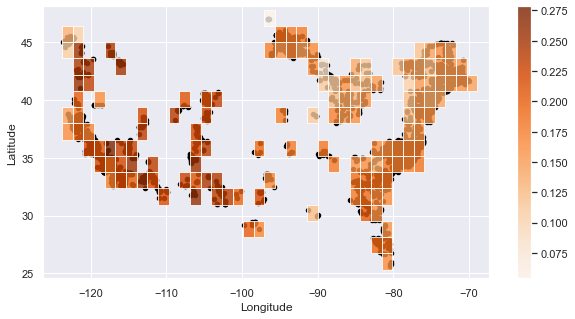

In [8]:

# GeoEncode the data: 
df['geohash'] = df.apply(lambda x: gh.encode(x.Latitude, x.Longitude, precision=3), axis=1)
# Count occurences of each geoCode 
df['occurances'] = df['geohash'].groupby(df['geohash']).transform('count')
# Drop infrequent codes 
df.drop(df.index[df['occurances'] < 4], inplace = True) 
# Find teh coordinates of each geo-hash -> Not used in for this project. 
df['geohash_cord'] = df.apply(lambda rec: pgh.decode(rec['geohash']), axis=1).to_frame()
# Obtain the mean efficiency for each power plant. (This does not include when the power plant is turned off) 
df['mean'] = df[df.columns[1:12]].mean(axis = 1) 
# For each geohash, obtain the mean of the mean of all other efficiencies. 
df['geohashAverage'] = df['mean'].groupby(df['geohash']).transform('mean') # There will be many duplicates: This will be resulted in the printMap() funciton. 

# Print the map 
printMap(df)

# Map shows each power plant contained within a clustering box that is colored based on the average of the mean efficiencies of power plants within that box. 


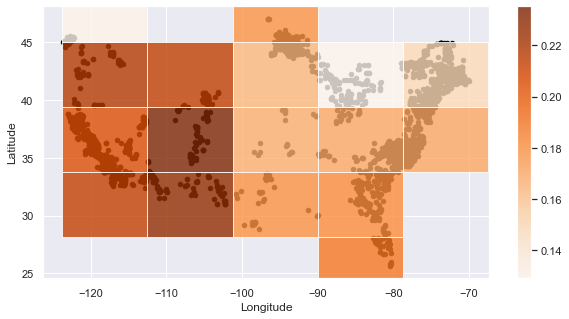

In [10]:
# Print the heat map with less boxes: 
# GeoEncode the data: 
df['geohash'] = df.apply(lambda x: gh.encode(x.Latitude, x.Longitude, precision=2), axis=1)
# Count occurences of each geoCode 
df['occurances'] = df['geohash'].groupby(df['geohash']).transform('count')
# Drop infrequent codes 
df.drop(df.index[df['occurances'] < 4], inplace = True) 
# Find teh coordinates of each geo-hash -> Not used in for this project. 
df['geohash_cord'] = df.apply(lambda rec: pgh.decode(rec['geohash']), axis=1).to_frame()
# Obtain the mean efficiency for each power plant. (This does not include when the power plant is turned off) 
df['mean'] = df[df.columns[1:12]].mean(axis = 1) 
# For each geohash, obtain the mean of the mean of all other efficiencies. 
df['geohashAverage'] = df['mean'].groupby(df['geohash']).transform('mean') # There will be many duplicates: This will be resulted in the printMap() funciton. 

# Print the map 
printMap(df)




